# Permuted v-test with nested family

For this example problem, we will just use a set of thickness ROI's, just family id as the block structure, and a single confounding variable of sex, and let's say neurocog1 as our target variable. Our dataset we are using is from the ABCD study.

### Load the data

In [1]:
import pandas as pd
import numpy as np

from neurotools.stats.permutations import permuted_v
from neurotools.loading.abcd import load_from_csv

In [2]:
# Get possible columns
csv_loc = '/home/sage/benchmark_methods/data/nda3.0.csv'
all_cols = list(pd.read_csv(csv_loc, nrows=0))

# Load thickness ROI data - ignore hemi and full mean for plotting
thick = [col for col in all_cols if 'smri_thick_cort.destrieux' in col and '_mean' not in col]

# Rest of needed columns
rest = ['C(sex_at_birth)', 'neurocog_pc1.bl', 'C(rel_family_id)']

# Load in all together
data = load_from_csv(cols=thick+rest, csv_loc=csv_loc, drop_nan=True)

### Run the permutation test

So how should be use the rel_family_id variable with information on the unique family of each subject? One option would be to use the values directly to define groups and the families themselves, where if we set parameter within_grp to True, this would mean that swaps will only be performed within group, so in terms of family, that means the only swaps that would take place are within families, swapping siblings data with each other. What that also means is that we would not be allowing any swaps to take place between say two random subjects with no other family members (this likely is not what we want from a null model).

On the other hand, we could use the family information to define block-wise swap. That is to say, so every singleton family is freely swapped with other singleton families, but any family of size 2, can only be swapped with another family of size 2. In this case though, what happens internally further is that the data is split into different variance groups. The set of all single-tons for example all fall under the same unique variance group, then for the set of families of size two, we compute two new variance groups, reflecting the subjects data which are allowed to swap. So for example:

- sub1 - family 1
- sub2 - family 2 
- sub3 - family 2 
- sub4 - family 3 
- sub5 - family 3 

The only possible swap here is subj2 and subj3's values with subj4 and subj5 as a block-level swap. So the different automatically computed variance groups would be:

- sub1 - family 1 - vg = 1
- sub2 - family 2 - vg = 2
- sub3 - family 2 - vg = 3
- sub4 - family 3 - vg = 2
- sub5 - family 3 - vg = 3

Since sub2 and sub4 can swap, and sub3 and sub5 can swap, so they have the same variance group. This is imporant because in calculating the v-score, stats are computed for each variance group seperately, then summed. But are these the swaps and variance groups we want? It seems more desirable actually that we would allow another level of swaps to occur, that is to say, members of the same family should be allowed to swap too, right? Likewise, there is no real reason the first member of family 2 should be in a seperate variance group from the second member of family 2, instead we likely want them all to be in the same variance group. So something like this:

- sub1 - family 1 - vg = 1

- sub2 - family 2 - vg = 2
- sub3 - family 2 - vg = 2

- sub4 - family 3 - vg = 2
- sub5 - family 3 - vg = 2

Where now what we are explicitly concerned with is not the unique family, but the size of the family.



In [3]:
unique, cnts = np.unique(data['rel_family_id'], return_counts=True)
data['family_size'] = data['rel_family_id'].replace(dict(zip(unique, cnts)))
np.unique(data['family_size'])

array([1., 2., 3., 5.])

In [4]:
data['neg_rel_family_id'] = -data['rel_family_id']
data['ones'] = 1

# Explicitly now
permutation_structure = data[['family_size', 'neg_rel_family_id', 'ones']]

So with this family size variable, an easy way to set this up is now within_grp=True. Where we allow swaps just within each of the unique groups.

In [5]:
pvals, original_scores, h0_vmax = permuted_v(tested_vars=data['neurocog_pc1.bl'],
                                             target_vars=data[thick],
                                             confounding_vars=data['sex_at_birth'],
                                             permutation_structure=permutation_structure,
                                             within_grp=True,
                                             n_perm=100,
                                             n_jobs=4,
                                             verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 18.4min remaining: 18.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 18.5min finished


### Make some plots of our results

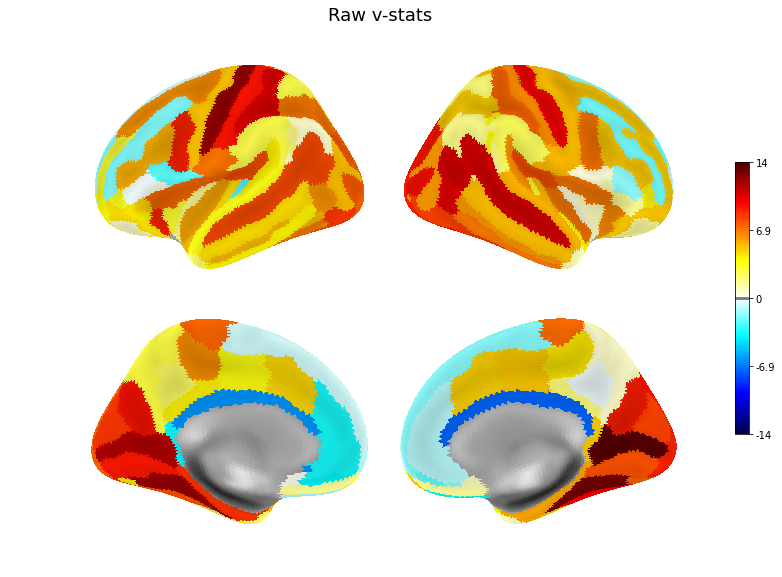

In [6]:
from neurotools.plotting import plot

# Put in series to plot
roi_names = list(data[thick])
v = pd.Series(original_scores, index=roi_names)

plot(v, title='Raw v-stats', threshold=.1)

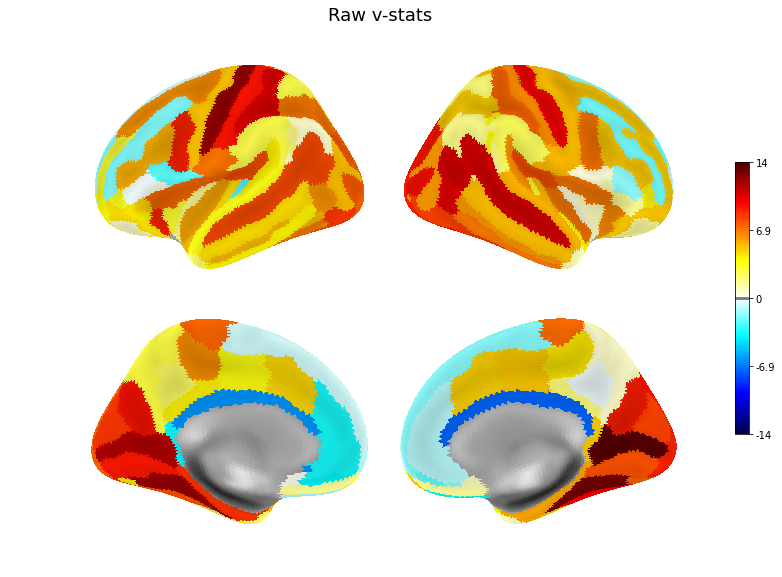

In [7]:
v = pd.Series(original_scores, index=roi_names)
plot(v, title='Raw v-stats', threshold=.1)

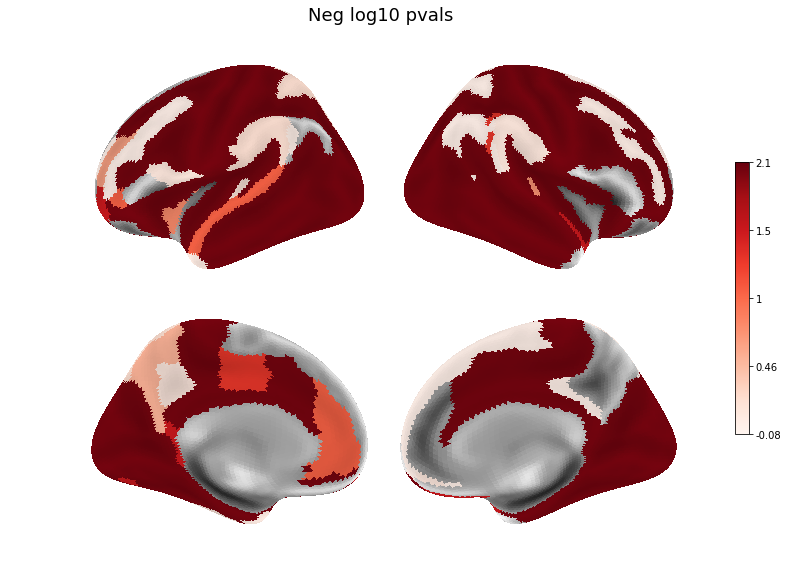

In [8]:
neg_log_pvals = -np.log10(pvals)
v = pd.Series(neg_log_pvals, index=roi_names)
plot(v, title='Neg log10 pvals', threshold=.001)

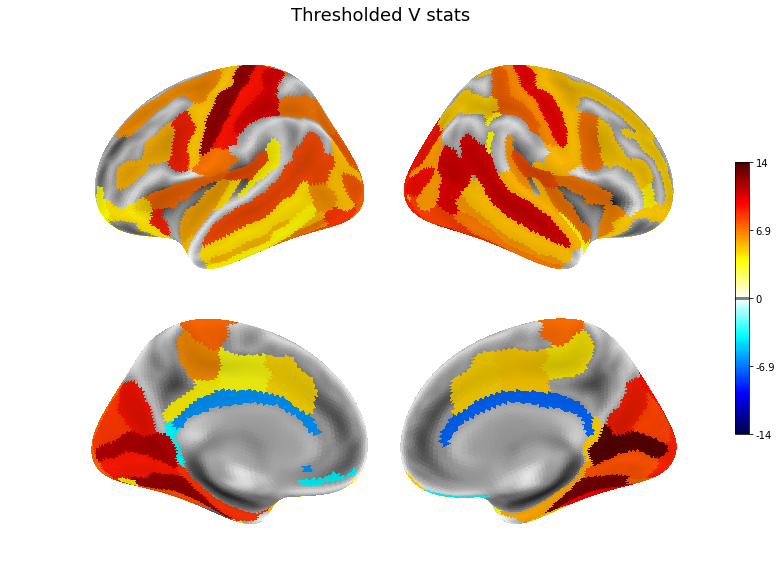

In [9]:
thresh_scores = original_scores.copy()
thresh_scores[pvals > .05] = 0

v = pd.Series(thresh_scores, index=roi_names)
plot(v, title='Thresholded V stats', threshold=.1)

### Part 2, permutations for ML

What about for ML / Multi-variate? In this example we will use the BPt library

In [10]:
import BPt as bp

data = bp.Dataset(data)
data = data.set_role('neurocog', 'target')
data = data.set_role(['sex_at_birth', 'family_size', 'neg_rel_family_id',
                      'ones', 'rel_family_id'], 'non input')

In [11]:
results = bp.evaluate('ridge_pipe', data, n_jobs=8)

Predicting target = neurocog_pc1.bl
Using problem_type = regression
Using scope = all (defining a total of 148 features).
Evaluating 10899 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (8719, 148)
Validation Set: (2180, 148)
Fit fold in 6.3 seconds.
explained_variance: 0.0888
neg_mean_squared_error: -0.5489

Training Set: (8719, 148)
Validation Set: (2180, 148)
Fit fold in 5.1 seconds.
explained_variance: 0.0798
neg_mean_squared_error: -0.5372

Training Set: (8719, 148)
Validation Set: (2180, 148)
Fit fold in 5.2 seconds.
explained_variance: 0.0795
neg_mean_squared_error: -0.5584

Training Set: (8719, 148)
Validation Set: (2180, 148)
Fit fold in 5.1 seconds.
explained_variance: 0.0647
neg_mean_squared_error: -0.5550

Training Set: (8720, 148)
Validation Set: (2179, 148)
Fit fold in 4.5 seconds.
explained_variance: 0.0960
neg_mean_squared_error: -0.5679



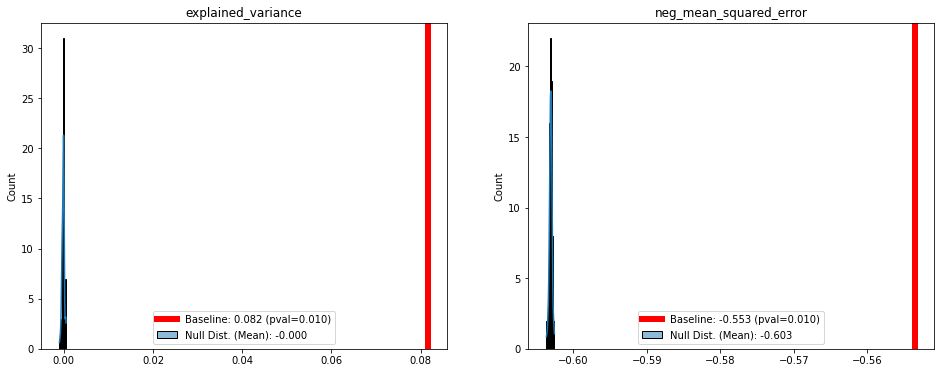

In [12]:
# Built in methof from BPt uses methods from neurotools internally
# Where we pass permutation structure to blocks with the same style input
pvals, pscores = results.run_permutation_test(n_perm=100,
                                              blocks=permutation_structure,
                                              within_grp=True,
                                              plot=True)